In [1]:


import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt



In [2]:


import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model



In [3]:


BATCH_SIZE = 64
IMAGE_SIZE = 256

CHANNELS=3  
EPOCHS=70



In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "corn",
    shuffle=True,
    
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 7315 files belonging to 4 classes.


potato_early_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato_Early_blight"

potato_lately_blight = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___Late_blight"

potato_healthy = "/content/drive/MyDrive/potato-disease/potato-disease/training/PlantVillage/Potato___healthy"

In [5]:
class_names = dataset.class_names

class_names

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())  #batch size 32 256 image size 

(64, 256, 256, 3)
[1 3 2 3 0 0 1 2 2 3 0 1 0 3 1 3 1 3 2 0 0 3 3 0 1 2 1 2 2 0 2 2 0 1 0 1 3
 3 1 0 2 0 2 1 0 3 3 3 1 3 3 1 2 0 2 3 3 1 1 2 2 2 0 2]


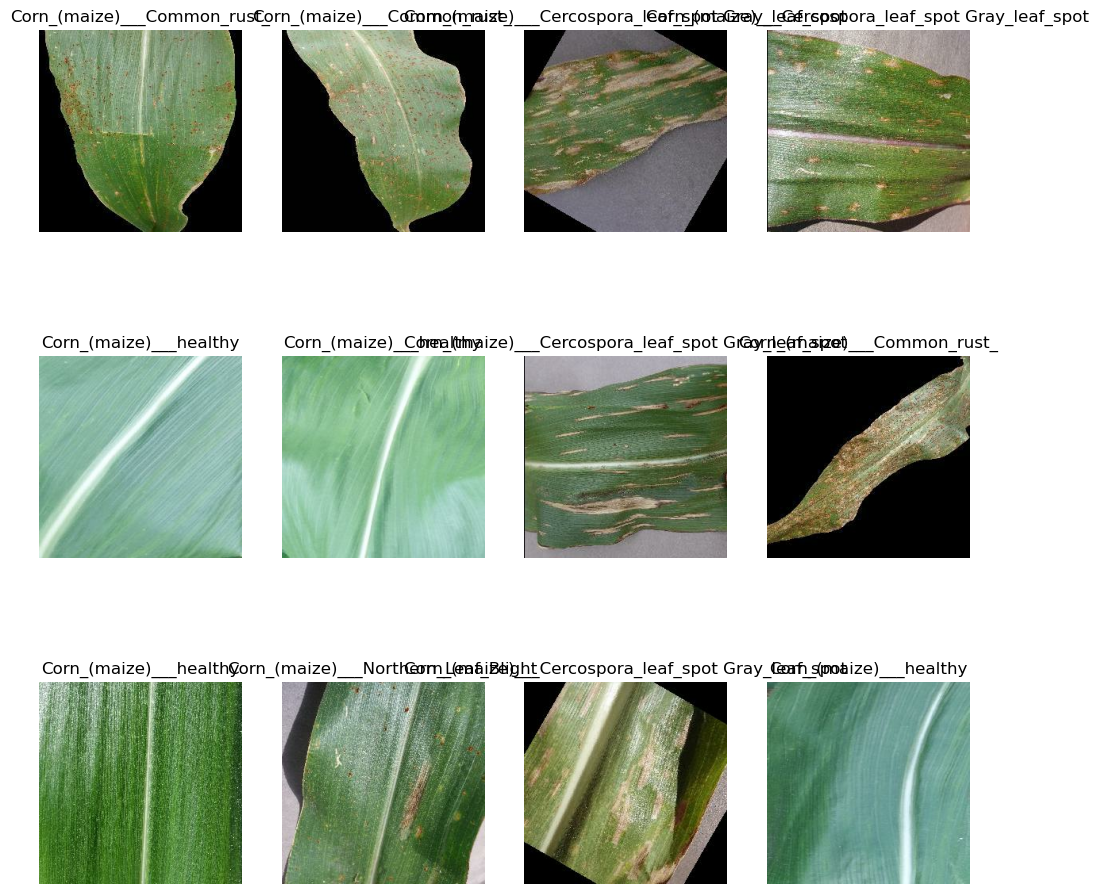

In [7]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):  
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) #plot
        plt.imshow(image_batch[i].numpy().astype("uint8"))  #random
        plt.title(class_names[labels_batch[i]]) 
        plt.axis("off")

# SPLITTING

80% ==>training 20% ==>10% for testing other 10% for validating

In [8]:
len(dataset)    #total images/batch size


115

In [9]:
train_size = 0.8                #580*.8  for training


In [10]:
len(dataset)*train_size


92.0

In [11]:
train_ds = dataset.take(92)     


In [12]:
len(train_ds)

92

In [13]:
test_ds = dataset.skip(92)


In [14]:
len(test_ds)

23

In [15]:
val_size=0.1


In [16]:
len(dataset)*val_size

11.5

In [17]:
val_ds = test_ds.take(11)


In [18]:
len(val_ds)

11

In [19]:
test_ds = test_ds.skip(11)


In [20]:
len(test_ds)

12

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=20000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

92

In [24]:
len(val_ds)

11

In [25]:
len(test_ds)

12

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


# Getting images into same size

In [27]:
resize_and_rescale = tf.keras.Sequential([
    
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
    
])


Changing the image style


In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


BUILDING THE MODEL


In [29]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4


In [31]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [32]:
model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=70,
)

Epoch 1/70
92/92 [==============================] - 493s 5s/step - loss: 0.6467 - accuracy: 0.6817 - val_loss: 0.3660 - val_accuracy: 0.8594
Epoch 2/70
92/92 [==============================] - 410s 4s/step - loss: 0.2723 - accuracy: 0.8970 - val_loss: 0.3476 - val_accuracy: 0.8565
Epoch 3/70
92/92 [==============================] - 408s 4s/step - loss: 0.2000 - accuracy: 0.9235 - val_loss: 0.2890 - val_accuracy: 0.8665
Epoch 4/70
92/92 [==============================] - 397s 4s/step - loss: 0.1673 - accuracy: 0.9375 - val_loss: 0.2665 - val_accuracy: 0.8764
Epoch 5/70
92/92 [==============================] - 398s 4s/step - loss: 0.1486 - accuracy: 0.9391 - val_loss: 0.2231 - val_accuracy: 0.8949
Epoch 6/70
92/92 [==============================] - 443s 5s/step - loss: 0.1464 - accuracy: 0.9418 - val_loss: 0.2350 - val_accuracy: 0.9020
Epoch 7/70
92/92 [==============================] - 451s 5s/step - loss: 0.1266 - accuracy: 0.9512 - val_loss: 0.1813 - val_accuracy: 0.9247
Epoch 8/70
92

Epoch 59/70
92/92 [==============================] - 391s 4s/step - loss: 0.0452 - accuracy: 0.9832 - val_loss: 0.1191 - val_accuracy: 0.9545
Epoch 60/70
92/92 [==============================] - 391s 4s/step - loss: 0.0739 - accuracy: 0.9747 - val_loss: 0.1231 - val_accuracy: 0.9545
Epoch 61/70
92/92 [==============================] - 394s 4s/step - loss: 0.0639 - accuracy: 0.9795 - val_loss: 0.1180 - val_accuracy: 0.9616
Epoch 62/70
92/92 [==============================] - 394s 4s/step - loss: 0.0461 - accuracy: 0.9831 - val_loss: 0.1606 - val_accuracy: 0.9375
Epoch 63/70
92/92 [==============================] - 396s 4s/step - loss: 0.0437 - accuracy: 0.9848 - val_loss: 0.0870 - val_accuracy: 0.9702
Epoch 64/70
92/92 [==============================] - 398s 4s/step - loss: 0.0429 - accuracy: 0.9860 - val_loss: 0.1270 - val_accuracy: 0.9616
Epoch 65/70
92/92 [==============================] - 396s 4s/step - loss: 0.0410 - accuracy: 0.9856 - val_loss: 0.1208 - val_accuracy: 0.9602
Epoch 

In [36]:
scores = model.evaluate(test_ds)

12/12 [==============================] - 45s 1s/step - loss: 0.1090 - accuracy: 0.9701


In [37]:
scores

[0.10901904106140137, 0.9700520634651184]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 92}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
type(history.history['loss'])

list

In [42]:
len(history.history['loss'])

70

In [43]:
history.history['loss'][:5] 

[0.646709144115448,
 0.2723252773284912,
 0.20000743865966797,
 0.16732700169086456,
 0.1485629379749298]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(val_acc)

[0.859375, 0.8565340638160706, 0.8664772510528564, 0.8764204382896423, 0.8948863744735718, 0.9019886255264282, 0.9247159361839294, 0.9161931872367859, 0.9161931872367859, 0.9389204382896423, 0.9545454382896423, 0.9417613744735718, 0.9517045617103577, 0.9460227489471436, 0.9460227489471436, 0.9431818127632141, 0.9460227489471436, 0.9474431872367859, 0.9502840638160706, 0.9417613744735718, 0.953125, 0.9375, 0.9446022510528564, 0.9446022510528564, 0.9602272510528564, 0.9602272510528564, 0.9573863744735718, 0.9559659361839294, 0.9545454382896423, 0.9474431872367859, 0.9417613744735718, 0.9545454382896423, 0.96875, 0.9517045617103577, 0.9446022510528564, 0.9261363744735718, 0.9559659361839294, 0.9346590638160706, 0.9332386255264282, 0.9502840638160706, 0.9488636255264282, 0.953125, 0.9616477489471436, 0.9659090638160706, 0.9545454382896423, 0.9588068127632141, 0.9573863744735718, 0.9630681872367859, 0.9602272510528564, 0.9673295617103577, 0.9630681872367859, 0.9616477489471436, 0.9758522510

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

print(val_loss)

[0.3660140037536621, 0.34764182567596436, 0.2889921963214874, 0.2665485739707947, 0.2231411337852478, 0.2350197732448578, 0.18129634857177734, 0.16318528354167938, 0.20098565518856049, 0.14350782334804535, 0.12738575041294098, 0.13858221471309662, 0.15228906273841858, 0.16304230690002441, 0.12791267037391663, 0.133445143699646, 0.13425742089748383, 0.12907111644744873, 0.12325456738471985, 0.13362279534339905, 0.11905927956104279, 0.1396186500787735, 0.13210593163967133, 0.13475435972213745, 0.11211741715669632, 0.10752462595701218, 0.12492945790290833, 0.1119130402803421, 0.1134340688586235, 0.1272539347410202, 0.13204284012317657, 0.11600732803344727, 0.10379845649003983, 0.15389302372932434, 0.1632179319858551, 0.22585619986057281, 0.131008118391037, 0.18440060317516327, 0.18288494646549225, 0.11813623458147049, 0.14206717908382416, 0.1288682371377945, 0.11684319376945496, 0.09307157248258591, 0.16048696637153625, 0.1232328861951828, 0.11564815044403076, 0.13886745274066925, 0.13653

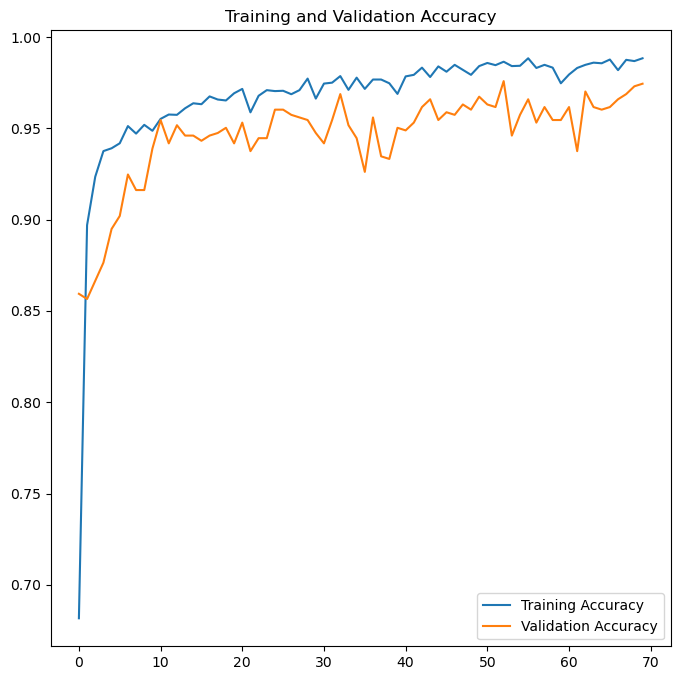

In [46]:
plt.figure(figsize=(8, 8))

plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.show()

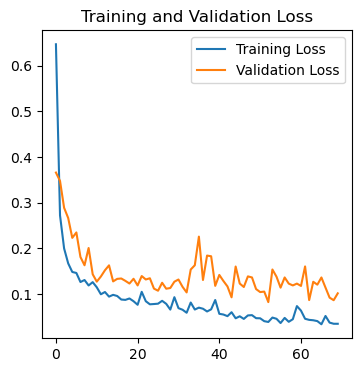

In [47]:
plt.figure(figsize=(4, 4))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

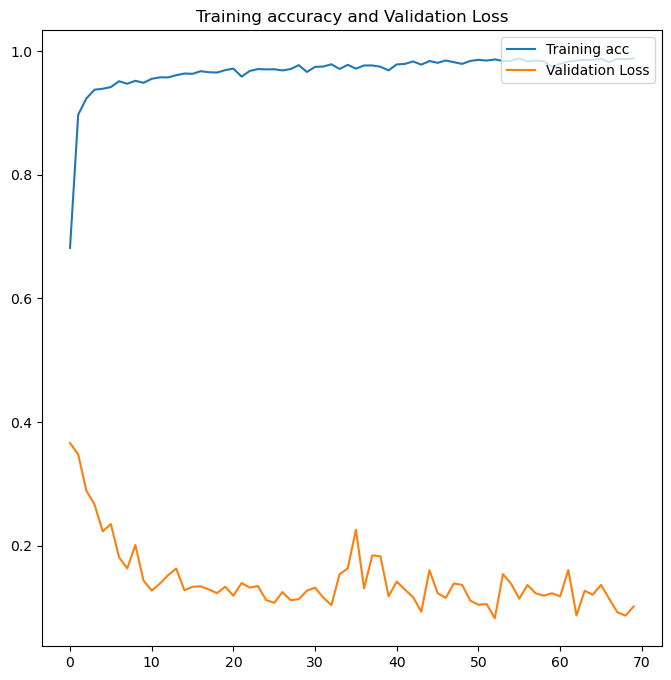

In [48]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), acc, label='Training acc')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training accuracy and Validation Loss')

plt.show()

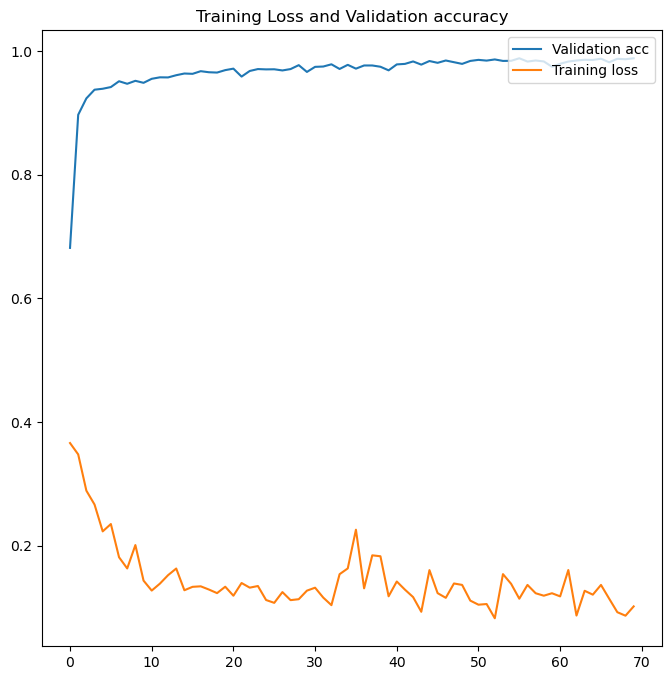

In [49]:
plt.figure(figsize=(8, 8))
plt.plot(range(EPOCHS), acc, label='Validation acc')
plt.plot(range(EPOCHS), val_loss, label='Training loss')
plt.legend(loc='upper right')
plt.title('Training Loss and Validation accuracy')

plt.show()

first image to predict
actual label: Corn_(maize)___healthy
2/2 [==============================] - 6s 545ms/step
predicted label: Corn_(maize)___healthy


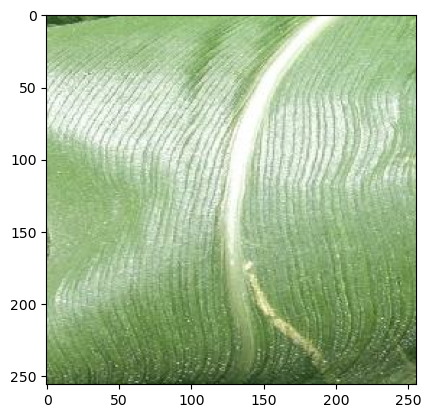

In [50]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 78ms/step


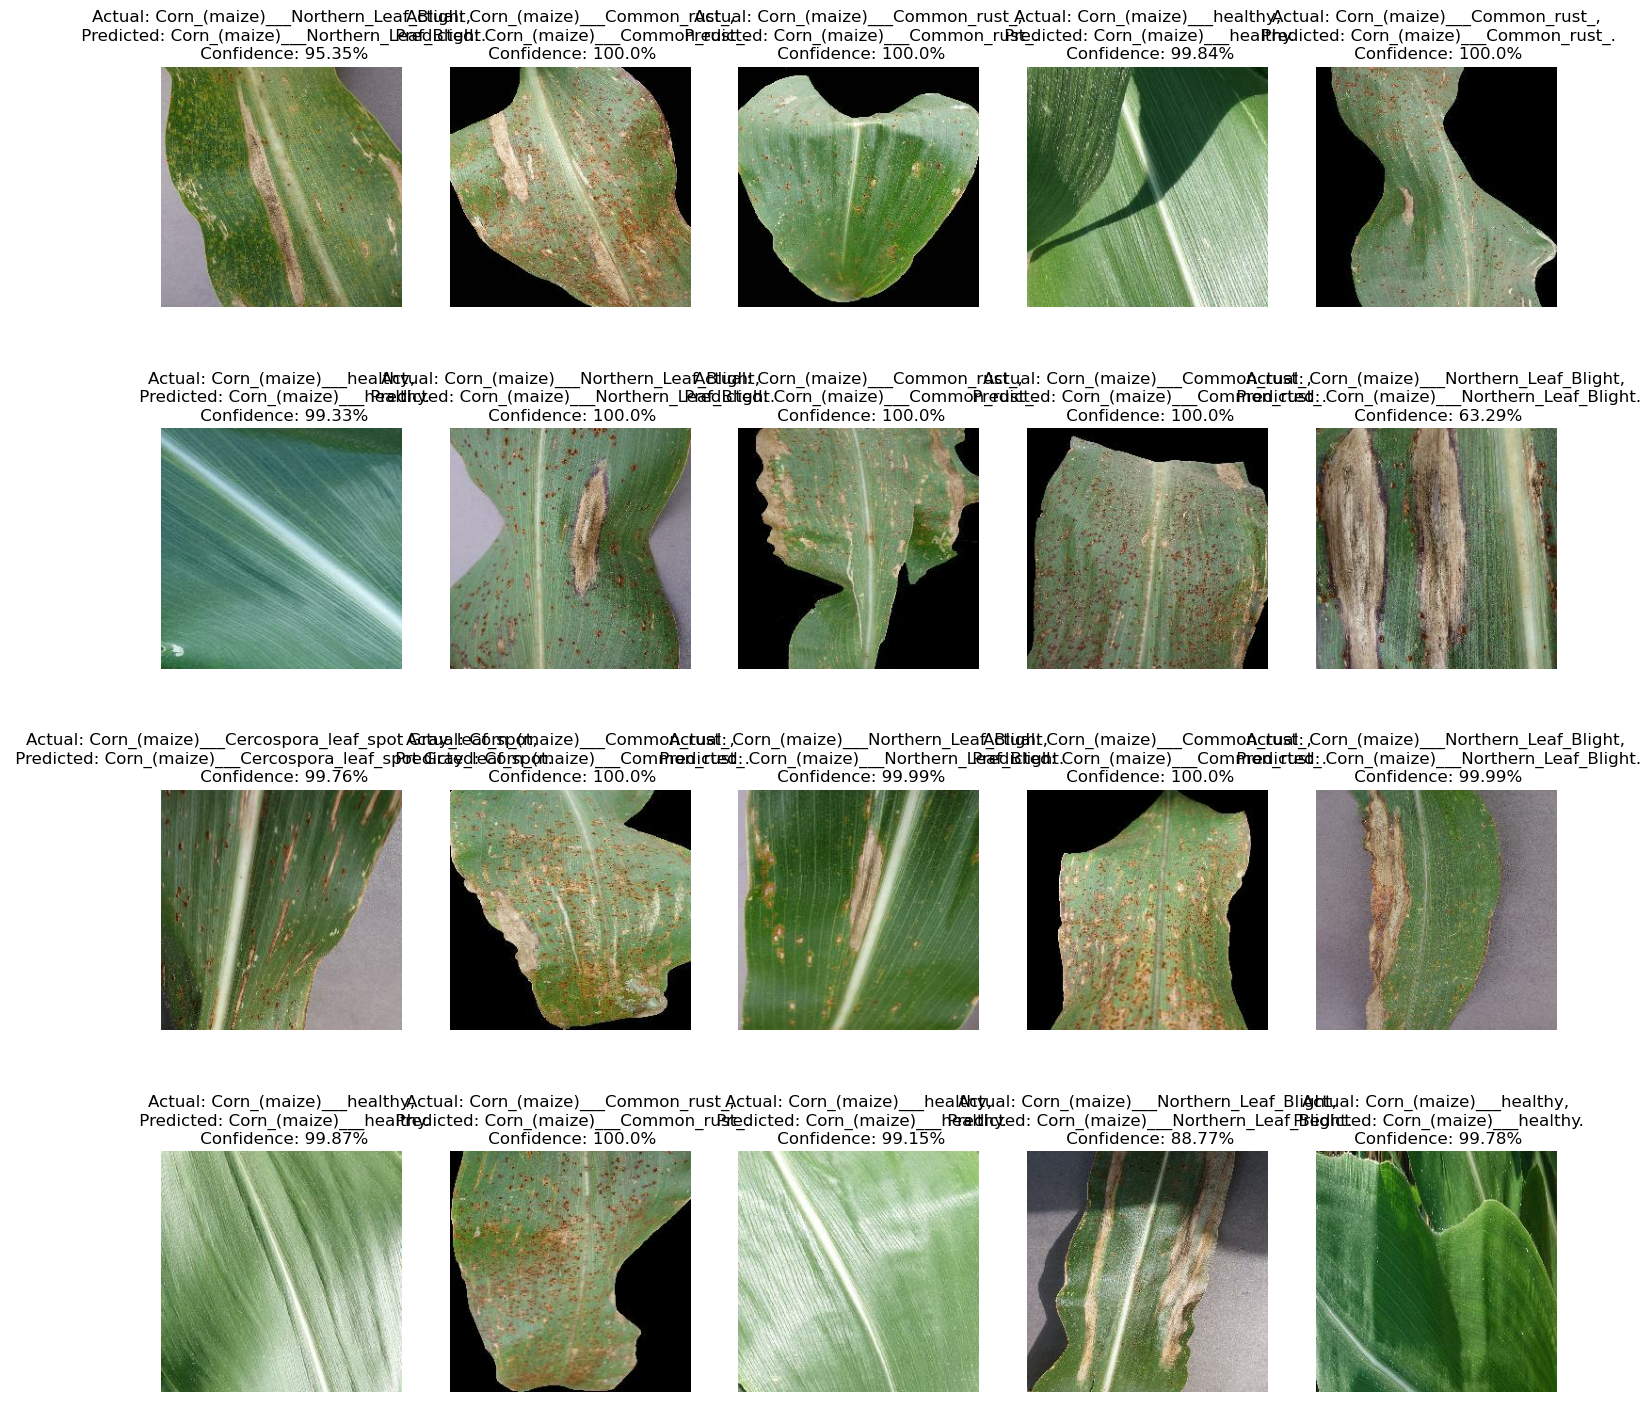

In [52]:
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [53]:
import os
os.listdir("../cornmodel")

['3']

In [54]:
import os
model_version=max([int(i) for i in os.listdir("../cornmodel") + [0]])+1
model.save(f"../cornmodel/{model_version}")

INFO:tensorflow:Assets written to: ../cornmodel/4\assets


INFO:tensorflow:Assets written to: ../cornmodel/4\assets


In [55]:
model.save("../corn.h5")